In [67]:
# Suppress debugging information about GPU
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import os.path
import sys
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import logging
from matplotlib import pyplot as plt
from numpy import mean, std
from keras.initializers import RandomUniform
from keras.layers import Dense, InputLayer
from keras.losses import MeanSquaredError
from keras.metrics import BinaryAccuracy
from keras.models import Sequential
from keras.optimizers import SGD
from keras.regularizers import L2, L1
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
from pathlib import Path
from monk_helpers import *

### Utilities

In [92]:
# Function that builds up a NN
def get_NN(X_len, neurons=4, lr=0.01, alpha=0.5, hidden_activation="tanh", lambda_reg=None, penalty=None):

  # random initialization
  random_init = RandomUniform(seed=SEED)

  # regularization
  regularizer = L1(l1=lambda_reg) if penalty == "L1" \
          else  L2(l2=lambda_reg) if penalty == "L2" \
          else  None

  # 1 hidden layer
  NN_model = Sequential()
  NN_model.add(InputLayer(input_shape=(X_len,)))
  NN_model.add(Dense(units=neurons,  activation=hidden_activation, kernel_initializer=random_init, 
                bias_initializer=random_init, kernel_regularizer=regularizer)
              )
  NN_model.add(Dense(units=1, activation="sigmoid", kernel_initializer=random_init, 
                bias_initializer=random_init, kernel_regularizer=regularizer)
              )

  NN_model.compile(optimizer=SGD(learning_rate=lr, momentum=alpha),loss=MeanSquaredError(), metrics=BinaryAccuracy())

  return NN_model

In [3]:
#utility to define a list of grids for GridSearchCV (as some values can conflict with other ones)
def list_grids(grids_dict):
    return [grids_dict[item] for item in grids_dict]

#utility to print results of model selection phase
def print_results(model_name,best_score,std_of_best, best_params):
    metric="mse"
    print(f"mean validation {metric} : {best_score} +/- {std_of_best} (std on val)")
    print("best parameters from grid search", best_params)

# Function that prints the classification report
def print_report_score(test_label, test_pred):
    print(classification_report(test_label, test_pred, target_names=['0', '1']))

In [26]:
def do_NN_plot(history):

    # Plot Accuracy
    plt.plot(history['binary_accuracy'])
    plt.plot(history['val_binary_accuracy'], linestyle="--", color="orange")
    plt.title(f'model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'test'], loc='lower right')
    plt.show()

    # Plot loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'],  linestyle="--", color="orange")
    plt.title(f'model MSE')
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.legend(['training', 'test'], loc='upper right')
    plt.show()

### Monk 1

In [4]:
# Datasets Path
TR_PATH = "./monks/datasets/monks-1.train"
TS_PATH = "./monks/datasets/monks-1.test"

X_train, y_train = read_ds(TR_PATH)
X_test, y_test = read_ds(TS_PATH)

#### Grid Search

In [23]:
NN = KerasClassifier(
    model=get_NN,
    X_len = len(X_train.columns),
    loss="mse",
    optimizer="sgd",
    shuffle=True,
    verbose=False,
    epochs=600,
    batch_size=4,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=1e-4, patience=15, restore_best_weights=True)]
)

custom_scores_monk = {
    "accuracy": "accuracy",
    "mse": make_scorer(mean_squared_error,greater_is_better=False)
}

NN_MONK1_GRID_DICT = {
  "unique_entry":{
    #"optimizer" : ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
    #"epochs" : [100, 300, 600],
    #"batch_size" : [4, 32, 64],
    "model__lr" : [0.2], # [0.01, 0.2, 0.25, 0.3]
    "model__alpha" : [0.6], # [0.5, 0.6, 0.7]
    "model__hidden_activation": ["tanh"],
    "model__neurons": [4] # [2, 3, 4]
  }
}

grid = GridSearchCV(NN,
                    param_grid=list_grids(NN_MONK1_GRID_DICT),
                    scoring=custom_scores_monk,
                    refit="mse",
                    cv=CV,
                    return_train_score=True,
                    n_jobs=-1,
        )

#### Evaluation and Assessment

In [24]:
grid.fit(X_train, y_train)
print("Best parameters: " + str(grid.best_params_) + " score: " + str(grid.best_score_))

Best parameters: {'model__alpha': 0.6, 'model__hidden_activation': 'tanh', 'model__lr': 0.2, 'model__neurons': 4} score: -0.008


Train set Accuracy: 1.0
Model Assessment: 1.0


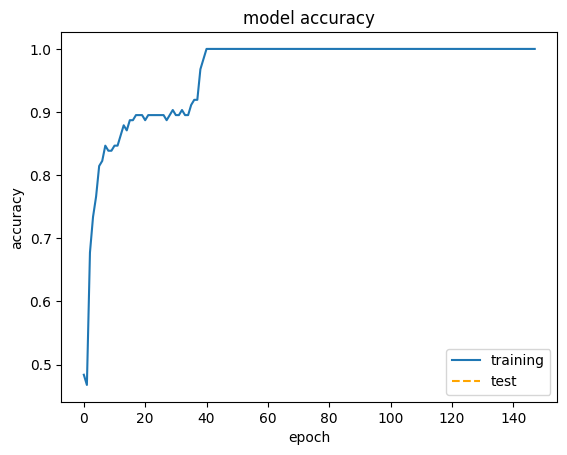

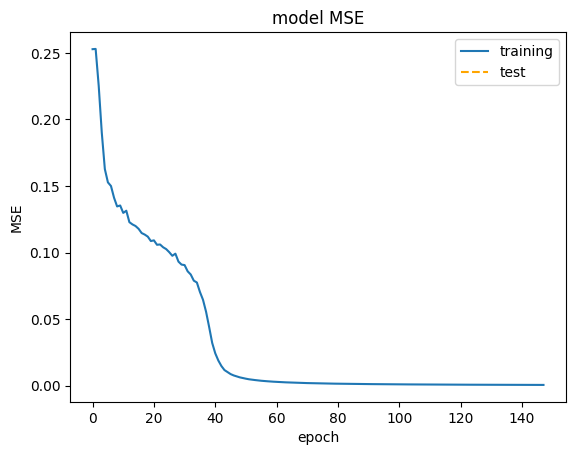

In [25]:
NN_monk1 = grid.best_estimator_

print("Train set Accuracy: " + str(NN_monk1.score(X_train, y_train)))

print("Model Assessment: " + str(NN_monk1.score(X_test, y_test)))

do_NN_plot(NN_monk1.history_)

### Monk 2

In [38]:
# Datasets Path
TR_PATH = "./monks/datasets/monks-2.train"
TS_PATH = "./monks/datasets/monks-2.test"

X_train, y_train = read_ds(TR_PATH)
X_test, y_test = read_ds(TS_PATH)

#### Grid Search

In [41]:
NN = KerasClassifier(
    model=get_NN,
    X_len = len(X_train.columns),
    loss="mse",
    optimizer="sgd",
    shuffle=True,
    verbose=False,
    epochs=600,
    batch_size=4,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=1e-4, patience=15, restore_best_weights=True)]
)

custom_scores_monk = {
    "accuracy": "accuracy",
    "mse": make_scorer(mean_squared_error,greater_is_better=False)
}

NN_MONK2_GRID_DICT = {
  "unique_entry":{
    #"optimizer" : ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
    #"epochs" : [100, 300, 600],
    #"batch_size" : [4, 32, 64],
    "model__lr" : [0.1], # [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
    "model__alpha" : [0.6], # [0.5, 0.6, 0.7]
    "model__hidden_activation": ["tanh"],
    "model__neurons": [3] # [2, 3, 4]
  }
}

grid = GridSearchCV(NN,
                    param_grid=list_grids(NN_MONK2_GRID_DICT),
                    scoring=custom_scores_monk,
                    refit="mse",
                    cv=CV,
                    return_train_score=True,
                    n_jobs=-1,
        )

#### Evaluation and Assessment

In [42]:
grid.fit(X_train, y_train)
print("Best parameters: " + str(grid.best_params_) + " score: " + str(grid.best_score_))

Best parameters: {'model__alpha': 0.6, 'model__hidden_activation': 'tanh', 'model__lr': 0.1, 'model__neurons': 3} score: 0.0


Train set Accuracy: 1.0
Model Assessment: 1.0


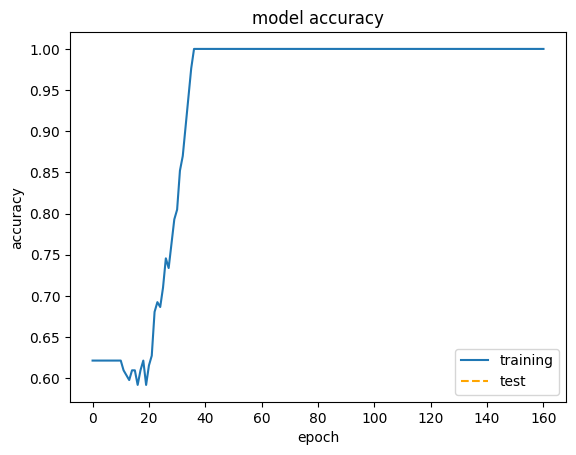

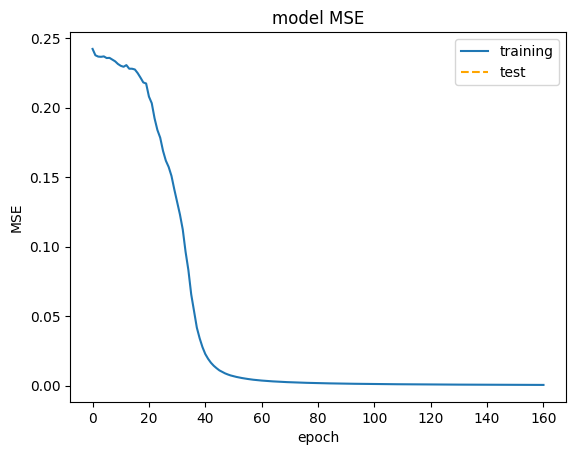

In [43]:
NN_monk2 = grid.best_estimator_

print("Train set Accuracy: " + str(NN_monk2.score(X_train, y_train)))

print("Model Assessment: " + str(NN_monk2.score(X_test, y_test)))

do_NN_plot(NN_monk2.history_)

### Monk 3

In [44]:
# Datasets Path
TR_PATH = "./monks/datasets/monks-3.train"
TS_PATH = "./monks/datasets/monks-3.test"

X_train, y_train = read_ds(TR_PATH)
X_test, y_test = read_ds(TS_PATH)


#### Grid Search

In [93]:
NN = KerasClassifier(
    model=get_NN,
    X_len = len(X_train.columns),
    loss="mse",
    optimizer="RMSprop",
    shuffle=True,
    verbose=False,
    epochs=600,
    batch_size=4,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=1e-4, patience=15, restore_best_weights=True)]
)

custom_scores_monk = {
    "accuracy": "accuracy",
    "mse": make_scorer(mean_squared_error,greater_is_better=False)
}

NN_MONK3_GRID_DICT = {
  "unique_entry":{
    #"optimizer" : ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
    #"epochs" : [100, 300, 600],
    #"batch_size" : [4, 32, 64],
    "model__lr" : [0.15], # [0.01, 0.1, 0.15, 0.16, 0.2, 0.25, 0.3],
    "model__alpha" : [0.5], # [0.4, 0.5, 0.55, 0.6, 0.7],
    "model__hidden_activation": ["tanh"],
    "model__penalty":["L2"], # ["L1", "L2"],
    "model__lambda_reg": [0.005], # [0.0001, 0.001, 0.005, 0.007, 0.009, 0.01],
    "model__neurons": [3, 4] # [2, 3, 4]
  }
}

grid = GridSearchCV(NN,
                    param_grid=list_grids(NN_MONK3_GRID_DICT),
                    scoring=custom_scores_monk,
                    refit="mse",
                    cv=CV,
                    return_train_score=True,
                    n_jobs=-1,
        )

#### Evaluation and Assessment

In [94]:
grid.fit(X_train, y_train)
print("Best parameters: " + str(grid.best_params_) + " score: " + str(grid.best_score_))

Best parameters: {'model__alpha': 0.5, 'model__hidden_activation': 'tanh', 'model__lambda_reg': 0.005, 'model__lr': 0.15, 'model__neurons': 4, 'model__penalty': 'L2'} score: -0.09066666666666665


Train set Accuracy: 0.9344262295081968
Model Assessment: 0.9722222222222222


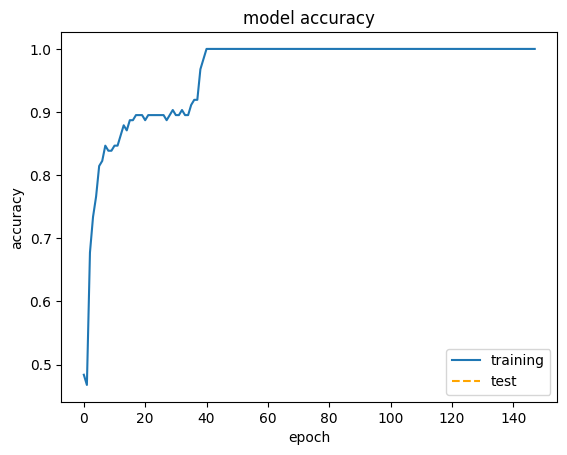

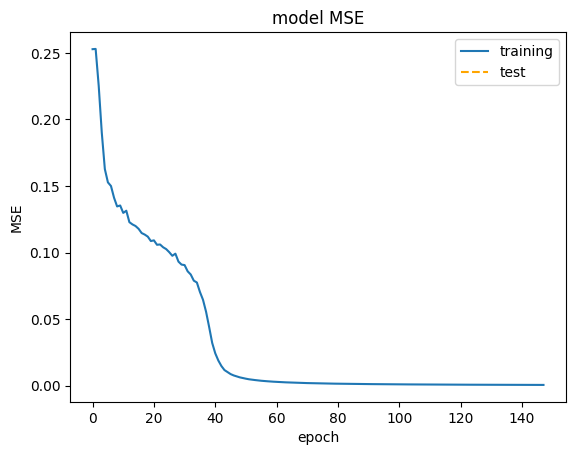

In [95]:
NN_monk3 = grid.best_estimator_

print("Train set Accuracy: " + str(NN_monk3.score(X_train, y_train)))

print("Model Assessment: " + str(NN_monk3.score(X_test, y_test)))

do_NN_plot(NN_monk1.history_)